# 2023 Final Exam 

### Course: AP3021

## Question 2

In [81]:
import matplotlib.pyplot as plt
import numpy as np

In [82]:
# T : Parcel virtual temperature
# Tv : Environment virtual temperature
# Height : 0--LFC(Level of free convection)  top--EL(Equilibrium level)
Height, T, Tv = np.loadtxt("Sounding_data.txt",unpack="true")

print(Height)
print(len(Height))

print(T)
print(len(T))

print(Tv)
print(len(Tv))

[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.
 6000. 6500. 7000. 7500.]
16
[302.641015 301.414936 300.052387 299.219994 297.945706 297.839665
 296.395461 295.957622 294.836952 294.042834 293.178223 292.128172
 291.41732  290.846195 289.566794 288.568096]
16
[308.45302  304.161056 299.426643 296.55262  292.179701 291.817268
 286.903579 285.422136 281.647781 278.988442 276.107374 272.628489
 270.285908 268.411115 264.234983 260.997853]
16


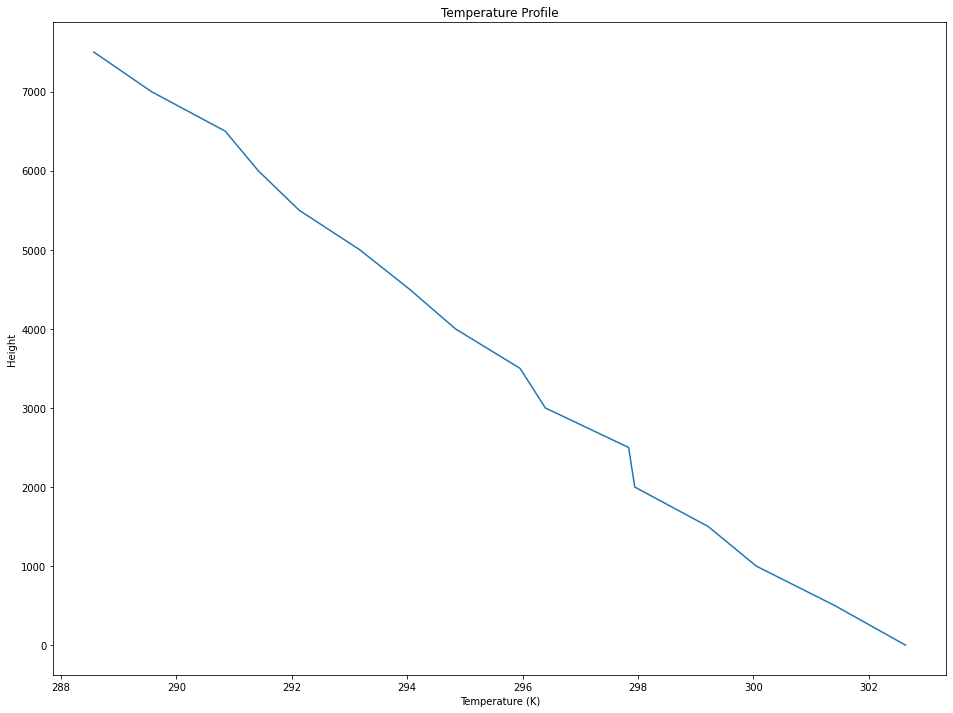

In [83]:
fig = plt.figure(figsize=(16,12))
plt.plot(T, Height)
plt.title("Temperature Profile")
plt.ylabel("Height")
plt.xlabel("Temperature (K)")

plt.show()

In [84]:
g = 9.8
para = (T - Tv) / Tv

### Trapezoid Method

In [85]:
def trapezoid_method(f, h, n):

    total = f[0]
    for i in range(1, n):
        total = total + 2 * f[i]
    total = total + f[n]

    ans = h * total / 2
    
    return ans

In [86]:
trapezoid_method_result = g * trapezoid_method(para, (7500.) / (len(T) - 1), len(T) - 1)
print("Trapezoid:", trapezoid_method_result)

Trapezoid: 3173.2169619851093


### Simpson 1/3 Method

In [87]:
def simpson_13_method(f, h, n):

    total = f[0]
    for i in range(1, n, 2):
        total = total + 4 * f[i]
    for j in range(2, n-1, 2):
        total = total + 2 * f[j]
    total = total + f[n]

    ans = h * total / 3
    
    return ans

In [88]:
simpson_13_method_result = g * simpson_13_method(para, (7500.) / (len(T) - 1), len(T) - 1)
print("Simpson 1/3:", simpson_13_method_result)

Simpson 1/3: 2673.154315758109


### Romberg Method

In [89]:
def cubic_inter(x0, x, y):

    x = np.array(x)
    y = np.array(y)
    # remove non finite values
    # indexes = np.isfinite(x)
    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)
    # print(size)
    x_diff = np.zeros(size - 1)
    for i in range(0, 15):
        x_diff[i] = x[i + 1] - x[i]

    y_diff = np.zeros(size - 1)
    for i in range(0, 15):
        y_diff[i] = y[i + 1] - y[i]

    # allocate buffer matrices
    Li = np.zeros(size)
    Li_1 = np.zeros(size-1)
    z = np.zeros(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = np.sqrt(2*x_diff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = x_diff[i-1] / Li[i-1]
        Li[i] = np.sqrt(2*(x_diff[i-1]+x_diff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(y_diff[i]/x_diff[i] - y_diff[i-1]/x_diff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = x_diff[-1] / Li[i-1]
    Li[i] = np.sqrt(2*x_diff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    count = 0

    for i in range(0, len(x)):
        if x0[0] > x[i]:
            count += 1
        else:
            break

    xi1, xi0 = x[count], x[count - 1]
    yi1, yi0 = y[count], y[count - 1]
    zi1, zi0 = z[count], z[count - 1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + zi1/(6*hi1)*(x0-xi0)**3 + (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    
    return f0

In [90]:
def trap_eq(a, b, n):

    h = (b - a) / n
    x = a
    sum_tra = cubic_inter([x], Height, para)[0] 

    for i in range(1, n):
        x = x + h
        sum_tra = sum_tra + 2 * cubic_inter([x], Height, para)[0]

    sum_tra = sum_tra + cubic_inter([b], Height, para)[0]
    Trap = (b - a) * sum_tra / (2 * n)
    
    return Trap

In [91]:
def I(j, k, a, b):

    if k == 1:
        n = 2 ** (j - 1)

        return trap_eq(a, b, n)
    else:
        i_jk = ((4 ** (k-1)) * I(j + 1, k - 1, a, b) - I(j, k - 1, a, b)) / ((4 ** (k - 1)) - 1)

        return i_jk

In [92]:
def romberg_method(a, b, es):
    i_ter = 0
    while True:
        i_ter = i_ter + 1

        for k in range(2, i_ter + 2):
            j = 2 + i_ter - k

        ea = abs((I(1, i_ter + 1, a, b) - I(2, i_ter, a, b)) / I(1, i_ter + 1, a, b)) * 100
        if ea < es:
            break

    return I(1, i_ter + 1, a, b)

In [93]:
romberg_method_result = g * romberg_method(0., 7500., 0.005) 
print("Romberg:", romberg_method_result)

Romberg: 3169.6285635767013
